In [5]:
import numpy as np
import random
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

# Initialize OpenAI for Breakout
env = gym.make("Breakout-v0")


# Hyper parameters for policy gradient model
global num_actions, discount, batch_size
num_actions = 3 # env.action_space.n # 6
discount = 0.99
save_every = 50
train_every = 1
reward_factor = 1.3
max_episode = 100000 # When to terminate traininig
# initial_exp = -1 # Initial exploration probability
# final_exp = 0.01 # Final exploration probability

# Hyper parameters for Network
global dropout
dropout = 0.8
learning_rate=0.001
decay_ = 0.95
epsilon_ = 1e-8
FC_param = {'FC_1':770}

# Initialize parameter for policy gradient model 
observation = env.reset()
image_old  = None
images, fake_labels, rewards_std, action_hist, reward_hist, reward_runn = [], [], [], [], [], []
reward_episode = 0

# Build network
def Network(image_, FC_param):
    
    FC_tmp = tf.contrib.layers.flatten(image_, scope='Flatten')
    
    for key,value in FC_param.items():
        FC_tmp = tf.layers.dense(inputs=FC_tmp, 
                                 units=value,
                                 kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                     stddev=1./np.sqrt(5000), 
                                                                                     dtype=tf.float32),
                                 activation=tf.nn.relu,
                                 use_bias=False,
                                 name=key)
        
    FC_tmp = tf.nn.dropout(FC_tmp, dropout)
    
    logits = tf.layers.dense(inputs=FC_tmp, 
                             units=num_actions, 
                             kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                 stddev=1./np.sqrt(500), 
                                                                                 dtype=tf.float32),
                             use_bias=False,
                             name='Logits')
    
    action_probs = tf.nn.softmax(logits, name='SoftMax')
    
    return action_probs

# Get discounted reward and normalize it
def discount_norm(rew):
    rew_func = lambda a, v: a*discount + v # Reward function
    
    rew_reverse = tf.scan(rew_func, tf.reverse(rew,[True, False]))
    discounted_rew = tf.reverse(rew_reverse,[True, False])
    
    mean, variance= tf.nn.moments(discounted_rew, [0])
    discounted_rew -= mean
    discounted_rew /= tf.sqrt(variance + 1e-6)
    
    return discounted_rew

# Process image by cropping and binarizing
def process_obs(obs):
    obs = obs[32:196,8:152]
    obs = obs[::2,::2,0]
    obs[obs != 0] = 1 
    return obs.astype(np.float)

# Break down into batch jobs to reduce GPU/CPU load
def gen_batch_index(num_of_steps):
    batch_index = []
    start = 0
    for index in np.array(range(0,len(images),batch_size)):
        end=index
        if end > 0:
            batch_index.append([start,end])
        start=index
    end = len(images)
    batch_index.append([start,end])
    return batch_index

# Build model
with tf.Graph().as_default() as g:
    with tf.device("/cpu:0"):
        image_ = tf.placeholder(dtype=tf.float32, shape=[None, 82, 72,1],name="image")
        fake_label_ = tf.placeholder(dtype=tf.float32, shape=[None, num_actions],name="fake_label")
        reward_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="reward")

        discounted_epr = discount_norm(reward_) # Get policy gradient

        tf_aprob = Network(image_,FC_param)
        loss = tf.nn.l2_loss(fake_label_-tf_aprob) # Define loss
        optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=decay_, epsilon=epsilon_)
        grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=discounted_epr)
        train_op = optimizer.apply_gradients(grads)

# Main program
with g.as_default(), tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    saver = tf.train.Saver(tf.global_variables())
    
    # Load from last session or start over
    try:
        episode_number = pickle.load(open('PG-Breakout-ckpt-2/last-episode.p','rb'))
        saver.restore(sess, 'PG-Breakout-ckpt-2\\Breakout.ckpt-'+str(episode_number))
        reward_hist = pickle.load(open('PG-Breakout-ckpt-2/all_reward.p','rb'))
        print('Continue from last saved episode')
    except:
        print('Training from beginning')
        episode_number = 0
        
    # Starting playing
    while episode_number<=max_episode:
    #     if True: env.render()
        image_proc = process_obs(observation)
        image_diff = image_proc - image_old if image_old is not None else np.zeros((82, 72))
        image_old = image_proc

        # Uniformly pick an action
        feed_step = {image_: np.reshape(image_diff, (1,82, 72,1))}
        aprob = sess.run(tf_aprob,feed_step) ; aprob = aprob[0,:]
        
#         # Epsilon greedy exploration
#         ratio = np.max((max_episode - episode_number)/max_episode, 0)
#         exploration_prob = (initial_exp - final_exp) * ratio + final_exp
        action = np.argmax(aprob)
#         if random.random() < exploration_prob:
#             action = random.randint(0, num_actions-1)
#         else:
#             action = action = np.random.choice(num_actions, p=aprob)
        
        # Generate fake label for back prop
        label = np.zeros_like(aprob) ; label[action] = 1

        # Input action to OpenAI and get feedback
        observation, reward, done, info = env.step(action+1)
        reward_episode += reward

        # Record for training
        images.append(image_diff); fake_labels.append(label); rewards_std.append(reward); action_hist.append(action+1)

        # Training
        if done:
            
            if episode_number % train_every == 0:
                
                feed_episode = {image_: np.array(images).reshape(-1, 82, 72, 1), 
                        fake_label_: np.array(fake_labels).reshape(-1,num_actions), 
                        reward_: np.array([i*reward_factor for i in rewards_std]).reshape(-1,1)}
                sess.run(train_op,feed_episode)
                    
                # Clear memory
                images, fake_labels, rewards_std, action_hist = [], [], [], []
            
            # Bookkeeping
            reward_hist.append(reward_episode)
            reward_runn.append(reward_episode)
            episode_number += 1
            observation = env.reset()
            print('\tep {}: reward: {}'.format(episode_number, reward_episode))
            reward_episode = 0
            
            # Save model
            if episode_number % save_every == 0:
                saver.save(sess, 'PG-Breakout-ckpt-2/Breakout.ckpt', global_step=episode_number)
                print('Model saved, mean reward is',np.mean(reward_runn))
                pickle.dump(episode_number,open('PG-Breakout-ckpt-2/last-episode.p','wb'))
                pickle.dump(reward_hist,open('PG-Breakout-ckpt-2/all_reward.p','wb'))
                reward_runn = []


[2017-04-24 01:15:31,856] Making new env: Breakout-v0


Continue from last saved episode
	ep 28651: reward: 3.0
	ep 28652: reward: 5.0
	ep 28653: reward: 10.0
	ep 28654: reward: 6.0
	ep 28655: reward: 7.0
	ep 28656: reward: 5.0
	ep 28657: reward: 7.0
	ep 28658: reward: 7.0
	ep 28659: reward: 9.0
	ep 28660: reward: 7.0
	ep 28661: reward: 7.0
	ep 28662: reward: 6.0
	ep 28663: reward: 6.0
	ep 28664: reward: 6.0
	ep 28665: reward: 4.0
	ep 28666: reward: 5.0
	ep 28667: reward: 5.0
	ep 28668: reward: 7.0
	ep 28669: reward: 8.0
	ep 28670: reward: 6.0
	ep 28671: reward: 7.0
	ep 28672: reward: 4.0
	ep 28673: reward: 8.0
	ep 28674: reward: 8.0
	ep 28675: reward: 3.0
	ep 28676: reward: 4.0
	ep 28677: reward: 7.0
	ep 28678: reward: 5.0
	ep 28679: reward: 10.0
	ep 28680: reward: 9.0
	ep 28681: reward: 8.0
	ep 28682: reward: 10.0
	ep 28683: reward: 4.0
	ep 28684: reward: 3.0
	ep 28685: reward: 8.0
	ep 28686: reward: 5.0
	ep 28687: reward: 3.0
	ep 28688: reward: 6.0
	ep 28689: reward: 7.0
	ep 28690: reward: 4.0
	ep 28691: reward: 9.0
	ep 28692: reward: 3.

KeyboardInterrupt: 

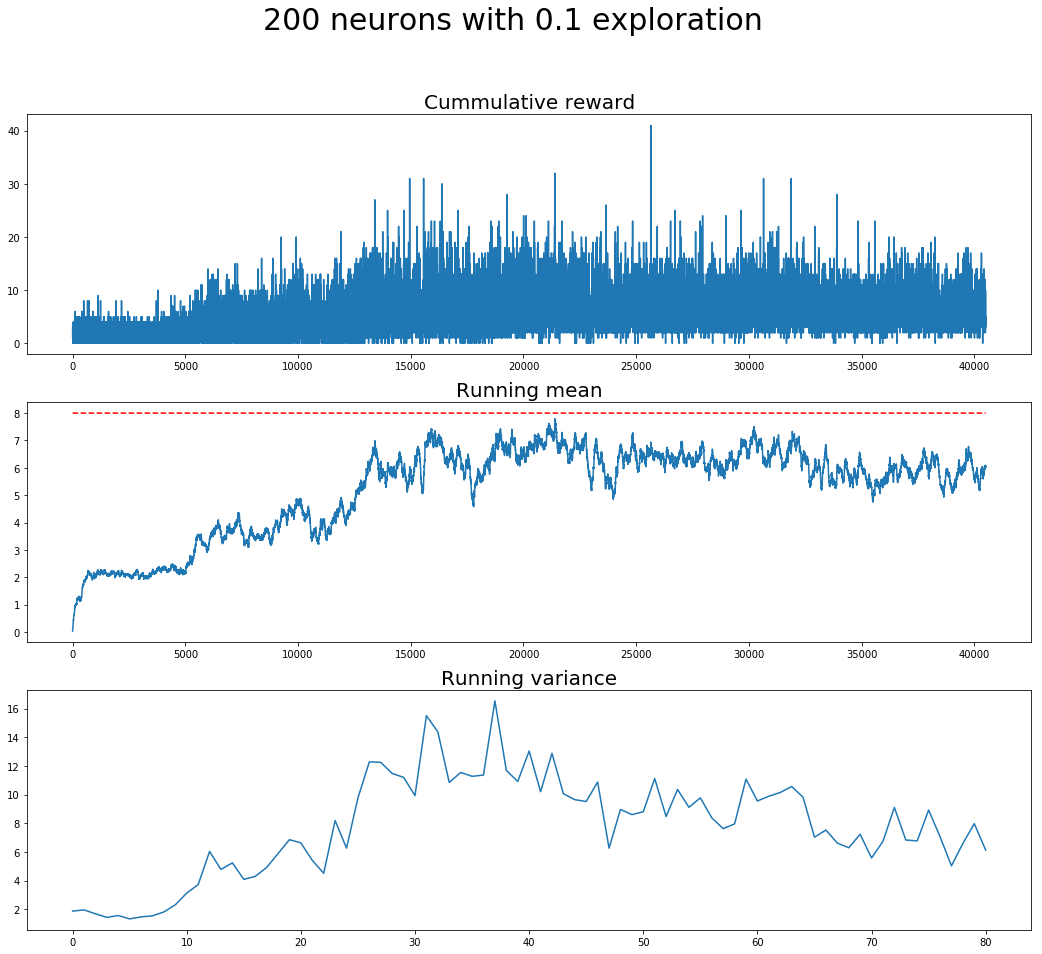

In [6]:
# Plotting
interval = 500

def get_mean_var(reward_hist):
    running_mean=[]; running_var=[]
    mean=0
    for i in range(len(reward_hist)):
        mean = 0.99*mean + 0.01*reward_hist[i]
        running_mean.append(mean)
    for i in range(np.floor(len(reward_hist)/interval).astype('int32')):
#         running_mean.extend([np.mean(reward_hist[i*interval:i*interval+interval+1])]*interval)
        running_var.extend([np.var(reward_hist[i*interval:i*interval+interval+1])])
    return running_mean, running_var

running_mean, running_var = get_mean_var(reward_hist)

fig,axe = plt.subplots(3,1,figsize=(18,15))
plt.suptitle('200 neurons with 0.1 exploration',fontsize=30)
axe[0].plot(np.array(reward_hist))
axe[0].set_title('Cummulative reward',fontsize=20)
axe[1].plot(np.array(running_mean))
axe[1].plot([8]*len(running_mean),'r--')
axe[1].set_title('Running mean',fontsize=20)
axe[2].plot(np.array(running_var))
axe[2].set_title('Running variance',fontsize=20)
plt.show()
fig.savefig('PG-Breakout-ckpt-2/ANN2.jpg')